In [3]:
import torch
import sys
import gensim
sys.path.append('../src')


from models.utils import get_model
from models.config import TOKENS_RAW_CUTOFF
from models.seq2seqattn import init_weights, EncRnn, DecRnn, Seq2SeqAttn

In [4]:
w2v_model = gensim.models.Word2Vec.load('../models/custom_w2v_intersect_GoogleNews_seq2seqattn') #get_model()
# w2ind from w2v
w2ind = {token: token_index for token_index, token in enumerate(w2v_model.wv.index2word)} 
# sorted vocab words
assert w2v_model.vocabulary.sorted_vocab == True
word_counts = {word: vocab_obj.count for word, vocab_obj in w2v_model.wv.vocab.items()}
word_counts = sorted(word_counts.items(), key=lambda x:-x[1])
words = [t[0] for t in word_counts]
# sentence marker token inds
sos_ind = w2ind['<sos>']
eos_ind = w2ind['<eos>']
# adjusted sequence length
SEQ_LEN = 5 + 2 # sos, eos tokens
# padding token for now
TRG_PAD_IDX = w2ind["."] # this is 0
# vocab, embed dims
VOCAB_SIZE, EMBED_DIM = w2v_model.wv.vectors.shape
VOCAB_SIZE, EMBED_DIM

(1931, 300)

In [5]:
sos_ind, eos_ind

(1929, 1930)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
enc = EncRnn(hidden_size=128, num_layers=2, embed_size=EMBED_DIM)
dec = DecRnn(hidden_size=128, num_layers=2, embed_size=EMBED_DIM, output_size=VOCAB_SIZE)
model = Seq2SeqAttn(enc, dec, TRG_PAD_IDX, VOCAB_SIZE, device).to(device)

In [7]:
model.load_state_dict(torch.load(
            '../src/pretrained_generators/model-epoch20.pt')
                     )
model.eval()

Seq2SeqAttn(
  (encoder): EncRnn(
    (embedding): Embedding(1931, 300)
    (memory_cell): GRU(300, 128, num_layers=2, batch_first=True, bidirectional=True)
    (linear): Linear(in_features=256, out_features=128, bias=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder): DecRnn(
    (attention): Attention(
      (attn): Linear(in_features=384, out_features=128, bias=True)
      (v): Linear(in_features=128, out_features=1, bias=False)
    )
    (embedding): Embedding(1931, 300)
    (memory_cell): GRU(556, 128)
    (linear): Linear(in_features=684, out_features=1931, bias=True)
    (dropout): Dropout(p=0, inplace=False)
  )
)

In [8]:
def get_seq(model, input_state, sos_ind, eos_ind, SEQ_LEN, device):
    src_tensor = input_state.unsqueeze(0).to(device)
    src_len = torch.Tensor([int(SEQ_LEN)])
    encoder_outputs, hidden = model.encoder(src_tensor, src_len)
    mask = model.create_mask(src_tensor.transpose(1,0)).to(device)
    trg_indexes = [sos_ind]
    attentions = torch.zeros(SEQ_LEN, 1, len(input_state))
    for i in range(SEQ_LEN):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)
        attentions[i] = attention
        return output

In [9]:
d = torch.load('../dat/processed/padded_vectorized_states_v3.pt')

In [10]:
for idx, (index, vects) in enumerate(d.items()):
        input_state, _= vects
        
        input_state = torch.cat((torch.LongTensor([sos_ind]), 
                                 input_state,
                                 torch.LongTensor([eos_ind])), 
                                 dim=0).to(device)
        out = get_seq(model, input_state, sos_ind, eos_ind, SEQ_LEN, device)
        
        break

<ipython-input-11-ce85e79191ac>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(torch.nn.functional.softmax(out).detach().cpu().numpy()[0])


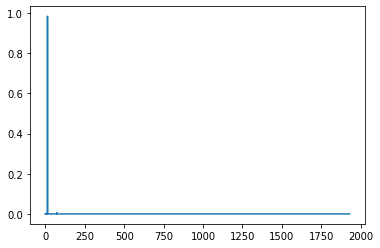

In [11]:
from matplotlib import pyplot as plt
plt.plot(torch.nn.functional.softmax(out).detach().cpu().numpy()[0])
plt.show()

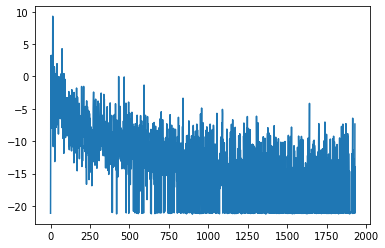

In [12]:
plt.plot(out.detach().cpu().numpy()[0])
plt.show()

In [13]:
def translate_sentence(words, input_state, next_state, model, eos_ind, max_len, device):
    
    model.eval()
    src_tensor = input_state.unsqueeze(0).to(device)
    src_len = torch.Tensor([int(max_len)])

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor.transpose(1,0)).to(device)
    # get first decoder input (<sos>)'s one hot
    trg_indexes = [next_state[0]]
    # create a array to store attetnion
    attentions = torch.zeros(max_len, 1, len(input_state))
    #print(attentions.shape)


    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        #print(trg_tensor.shape)
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)
        #print(F.softmax(output))
        attentions[i] = attention
        pred_token = output.argmax(1).item()
        if pred_token == eos_ind: # end of sentence.
            break
        trg_indexes.append(pred_token)
        
    trg_tokens = [words[int(ind)] for ind in trg_indexes]
    #  remove <sos>
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [14]:
from GAIL import get_cosine_sim

In [15]:
with torch.no_grad():
    for idx, (index, vects) in enumerate(d.items()):
        input_state, next_state = vects[0], vects[1]
        
        input_state = torch.cat((torch.LongTensor([sos_ind]), 
                                 input_state,
                                 torch.LongTensor([eos_ind])), 
                                 dim=0).to(device)
        
        next_state = torch.cat((torch.LongTensor([sos_ind]), 
                                next_state, 
                                torch.LongTensor([eos_ind])), 
                               dim=0).to(device)
        
        trg = next_state.unsqueeze(0).to(device)
        
        seq_len_tensor = torch.Tensor([int(SEQ_LEN)])
        
        output = model(input_state.unsqueeze(0), seq_len_tensor, trg)

        trg = trg.transpose(1,0)
        output_dim = output.shape[-1]                
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        translation, attention = translate_sentence(words, input_state, next_state, model, eos_ind, SEQ_LEN, device)

        # drop <sos>, <eos>
        init_act = [words[int(ind)] for ind in input_state.cpu().detach().numpy()][1:-1]
        expert_act = [words[int(ind)] for ind in next_state.cpu().detach().numpy()][1:-1]
        # drop multiple instances of padded token
        expert_act_unpadded = []
        for tok in expert_act:
            expert_act_unpadded.append(tok)
            #if tok == words[int(TRG_PAD_IDX)]:
            #    break
        init_act_unpadded = []
        for tok in init_act:
            init_act_unpadded.append(tok)
            #if tok == words[int(TRG_PAD_IDX)]:
            #    break        
        vectorized_expert_act = [w2v_model.wv[tok] for tok in expert_act_unpadded]
        vectorized_pred_act = [w2v_model.wv[tok] for tok in translation]
        cos_sim = get_cosine_sim(vectorized_expert_act, vectorized_pred_act, 
                                 type = None, 
                                 seq_len = SEQ_LEN-2,
                                 dim = EMBED_DIM)
        
        print(f'state = {" ".join(init_act_unpadded)}')
        print(f'expert = {" ".join(expert_act_unpadded)}')
        print(f'model = {" ".join(translation)}')
        print(cos_sim)
        print("\n")
        
        if idx>10:
            break

state = <time> <time> to go !
expert = yes . . . .
model = yes -- yes ? ?
0.18370254


state = <org> . . . .
expert = i hate him . .
model = really ? ? ? ?
0.0746113


state = good <time> , doctor .
expert = good <time> ! . .
model = good <time> ! ! !
0.81523645


state = i think so . .
expert = that 's my girl .
model = i 's my girl ?
0.70202327


state = did you do it ?
expert = no . . . .
model = uh , did this ?
-0.2002909


state = yes ! . . .
expert = why ? . . .
model = why 'm sorry ... ?
0.3674764


state = a god ? . .
expert = yes ! . . .
model = yes ! yes ! !
0.6293785


state = <org> ! <person> ! .
expert = yeah , <person> . .
model = yeah ? ! nice !
0.39774036


state = how 's everything ? .
expert = everything is everything . .
model = it 's everything treat them
0.38958332


state = hello there . . .
expert = ... hi . . .
model = hi there ?
0.12809686


state = it 's alive ! .
expert = hello there . . .
model = hello there ? !
0.4982065


state = <org> ? ! ? .
expert = it 